# Redes Neuronales - TP1

## Ej 3

Implemente una red de Hopfield ‘82 que aprenda patrones pseudo-aleatorios y estudie qué sucede
con los patrones aprendidos cuando algunas interconexiones son eliminadas al azar.
1. ¿Cómo cambia el error en función del porcentaje de sinapsis eliminadas?
2. ¿Cómo cambia la capacidad en función del porcentaje de sinapsis eliminadas?

Mi idea es tomar el ejercico 2 y cambiar los $W_{i,j}$ de a cierto \% y evaluar el error y capacidad. Para eliminar una sinapsis mando su weight a 0. 

In [24]:
# primero importamos numpy y hacer graficos
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [25]:
class evaluacion_capacidad_red_neuronal:
    def __init__(self, cantidad_neuronas):
        self.N = cantidad_neuronas
        self.W = None
        self.seed_vector = None
        self.mask = np.ones((cantidad_neuronas, cantidad_neuronas))

    def eliminar_sinapsis(self, porcentaje):
        N = self.N
        total_conexiones = N * (N - 1)
        eliminar = int(total_conexiones * porcentaje)

        rng = np.random.default_rng()
        indices = [(i, j) for i in range(N) for j in range(N) if i != j]
        seleccionados = rng.choice(len(indices), size=eliminar, replace=False)

        self.mask = np.ones((N, N))
        for idx in seleccionados:
            i, j = indices[idx]
            self.mask[i, j] = 0
        return


    def estado_aleatorio(self,correlacion=0):
        """permite generar estados para entrenar una red. devuelve una matriz lista para ser usada para calcular W"""

        N =self.N # cantidad de neuronas
        rng = np.random.default_rng()  # generador de números aleatorios

        if correlacion == 0:
            # Caso sin correlación: generamos vector completamente aleatorio
            vector = np.asarray(rng.integers(2, size=N)).reshape(-1, 1)
            return vector * 2 - 1  # de -1 a 1
        
        else:
            # Caso con correlación: generamos vector correlacionado con seed_vector
            p = (1 + correlacion) / 2  # Probabilidad de coincidir con la semilla
            
            seed_flat = self.seed_vector.flatten()
            mascara = rng.random(size=N) < p
            
            # Aplicar la regla con arrays 1D
            vector_correlacionado = np.where(mascara, seed_flat, -seed_flat)
            
            # Reconvertir a forma de columna
            return vector_correlacionado.reshape(-1, 1)


    def calcular_W(self, patrones, eta = 1):
        """
        Para calcular la W correspondiente a los patrones recibidos. Se asume que el formato es el que siempre se viene trabajando de vectores colmunas
        Se supone un "eta" unitario por comodidad. 
        """
        n_neuronas = self.N
        n_patrones = patrones.shape[1]

        X = patrones
        W = (X @ X.T - n_patrones*np.eye(n_neuronas)) * eta
        self.W = W* self.mask
        return
    


    
    def step_red_neuronal(self, patron_inicial):
        """
        Patrón inicial debe ser vector columna.
        """
        estado = np.copy(patron_inicial)
        estado = self.W @ estado
        estado = np.sign(estado)
        estado = np.where(estado == 0, 1, estado)  # Manejar ceros
        return estado
        

    def agregar_columna(self, datos,correlacion=0):
        """Esto lo uso para agregar de a 1 patron a la vez y no tener que hacer muchos randoms"""
        rnd = self.estado_aleatorio(correlacion=correlacion)
        datos = np.hstack((datos, rnd))
        return datos,rnd # debería ser cómodo para cuando itere para encontrar cuando fallan las cosas
    
    def comprobar_memoria(self, original):
        salida = self.step_red_neuronal(original)
        cant_bits_erroneos = np.sum(np.abs(original-salida)/2) # si hago la diferencia y divido por 2 debería obtener 
        # la cantidad de bits diferentes porque 1+1 = 2 ,1-1 = 0 ,-1-1 = -2
        return cant_bits_erroneos
    
    def actualizar_W(self, nuevo_patron, eta=1):
        """
        Actualiza la matriz de pesos de una red de Hopfield con un nuevo patrón. para optimizar un poco
        
        Parámetros
        ----------
        W_vieja : np.ndarray
            Matriz de pesos ya entrenada (N x N).
        nuevo_patron : np.ndarray
            Patrón nuevo en forma de vector columna (N x 1), con valores en {-1, +1}.
        eta : float
            Factor de aprendizaje (default=1).
            
        Retorna
        -------
        np.ndarray
            Nueva matriz de pesos W actualizada.
        """
        W_vieja = self.W
        n_neuronas = W_vieja.shape[0]
        x = nuevo_patron.reshape((n_neuronas, 1))

        # Hebb incremental con eliminación de autoconexiones
        W_nueva = W_vieja + eta * (x @ x.T - np.eye(n_neuronas))
        self.W = W_nueva* self.mask
        return

    

    def _estimar_errores_vs_patrones_correlacionados(self,correlacion, max_patron = -1):
        if max_patron == -1:
            max_patron = self.N

        lista_cant_patrones = []
        lista_errores = []
        datos = None

        for i in range(max_patron):
            if i == 0: 
                datos = self.estado_aleatorio(correlacion=0) # la semilla no requiere estar correlacionada a nada
                self.seed_vector = datos # la semilla para los proximos estados, asi todo está correlacionado
                self.calcular_W(datos) # la mete en el self
            else:
                datos,rnd = self.agregar_columna(datos,correlacion=correlacion) # rnd es el nuevo estado
                self.actualizar_W(rnd)


            # acá tenemos una matriz que va a ir aumentando en cantidad de patrones con las iteraciones
            # ahora invoco el cálculo de W
            

            # ahora lo que quiero es iterar por la cantidad de patrones en i y sumar la cantidad de errores
            errores_totales_bits = 0
            for k in range(i):
                estado_original_actual = datos[:,k] # el patrón k-ésimo
                error_actual = self.comprobar_memoria(estado_original_actual) # vamos a ir sumando
                error_actual = error_actual/(self.N * (i+1))
                errores_totales_bits = errores_totales_bits+error_actual

            lista_errores.append(errores_totales_bits)
            lista_cant_patrones.append(i+1)

        return lista_errores,lista_cant_patrones
    

    def _estimar_errores_vs_patrones_descorr(self, max_patron = -1):
        if max_patron == -1:
            max_patron = self.N

        lista_cant_patrones = []
        lista_errores = []
        datos = None # para que no lo llame unbound
        for i in range(max_patron):
            
            if i == 0: 
                datos = self.estado_aleatorio(correlacion=0)
                self.calcular_W(datos) # la mete en el self
            else:
                datos,rnd = self.agregar_columna(datos,correlacion=0) # rnd es el nuevo estado -> acá datos ya existe 
                self.actualizar_W(rnd)


            # acá tenemos una matriz que va a ir aumentando en cantidad de patrones con las iteraciones
            # ahora invoco el cálculo de W
            

            # ahora lo que quiero es iterar por la cantidad de patrones en i y sumar la cantidad de errores
            errores_totales_bits = 0
            for k in range(i):
                estado_original_actual = datos[:,k] # el patrón k-ésimo
                error_actual = self.comprobar_memoria(estado_original_actual) # vamos a ir sumando
                error_actual = error_actual/(self.N * (i+1))
                errores_totales_bits = errores_totales_bits+error_actual

            lista_errores.append(errores_totales_bits)
            lista_cant_patrones.append(i+1)

        return lista_errores,lista_cant_patrones


    def estimar_errores_vs_patrones(self, max_patron = -1, correlacion = 0):
        if correlacion == 0:
            lista_errores,lista_cant_patrones = self._estimar_errores_vs_patrones_descorr()
        else:
            lista_errores,lista_cant_patrones = self._estimar_errores_vs_patrones_correlacionados(correlacion)



        return lista_errores,lista_cant_patrones  

    def capacidad_dada_proba(self,lista_errores, lista_cant_patrones, prob_error_max):
        """
        Dada una curva de errores vs patrones, devuelve la máxima cantidad 
        de patrones que se pueden almacenar sin superar un error dado.
        
        Parámetros
        ----------
        lista_errores : list[float]
            Lista de probabilidades de error acumuladas (salida de estimar_errores_vs_patrones).
        lista_cant_patrones : list[int]
            Lista con la cantidad de patrones correspondientes.
        prob_error_max : float
            Probabilidad máxima de error permitida (ej: 0.05).
            
        Retorna
        -------
        int
            Cantidad máxima de patrones que cumple la condición.
        """
        capacidad = 0
        for err, cant in zip(lista_errores, lista_cant_patrones):
            if err <= prob_error_max:
                capacidad = cant
            else:
                break
        return capacidad
    

    def generar_patrones_correlacionados(self, cantidad, correlacion):
        """
        Genera 'cantidad' patrones binarios (-1,1) con una correlación aproximada 'correlacion' respecto a un patrón base.
        correlacion: valor entre 0 (totalmente aleatorio) y 1 (idéntico al patrón base).
        """
        N = self.N
        rng = np.random.default_rng()
        patron_base = rng.choice([-1, 1], size=(N, 1))
        patrones = [patron_base]
        p = (1 - correlacion) / 2
        for _ in range(cantidad - 1):
            ruido = rng.random((N, 1)) < p
            nuevo_patron = np.where(ruido, -patron_base, patron_base)
            patrones.append(nuevo_patron)
        return np.hstack(patrones)


El código es igual al del ej 2 con la diferencia que permite poner una máscara que hace que la matriz W olvide pesos. Así, se itera entre los porcentajes. Le fijé un umbral de 0.01 de proba de error. Con 1000 neuronas tarda ~14 minutos

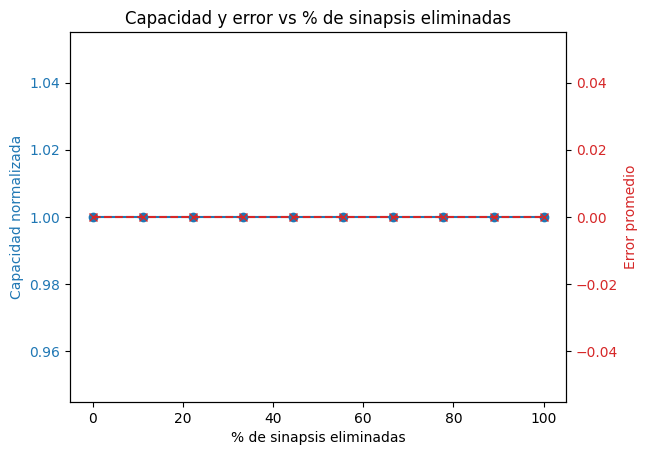

In [ ]:
n_neuronas = 1000
porcentajes = np.linspace(0, 1, 10)  # del 0% al 50% de sinapsis eliminadas
capacidades = []
errores_promedios = []

for p in porcentajes:
    ERN = evaluacion_capacidad_red_neuronal(n_neuronas)
    ERN.eliminar_sinapsis(p)  # aplicamos la máscara
    errores, n_patrones = ERN.estimar_errores_vs_patrones()
    capacidad = ERN.capacidad_dada_proba(errores, n_patrones, prob_error_max=0.01)
    
    capacidades.append(capacidad / n_neuronas)
    errores_promedios.append(np.mean(errores))

# Graficamos
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('% de sinapsis eliminadas')
ax1.set_ylabel('Capacidad normalizada', color=color)
ax1.plot(porcentajes*100, capacidades, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # segundo eje y para errores
color = 'tab:red'
ax2.set_ylabel('Error promedio', color=color)
ax2.plot(porcentajes*100, errores_promedios, marker='x', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Capacidad y error vs % de sinapsis eliminadas')
plt.show()


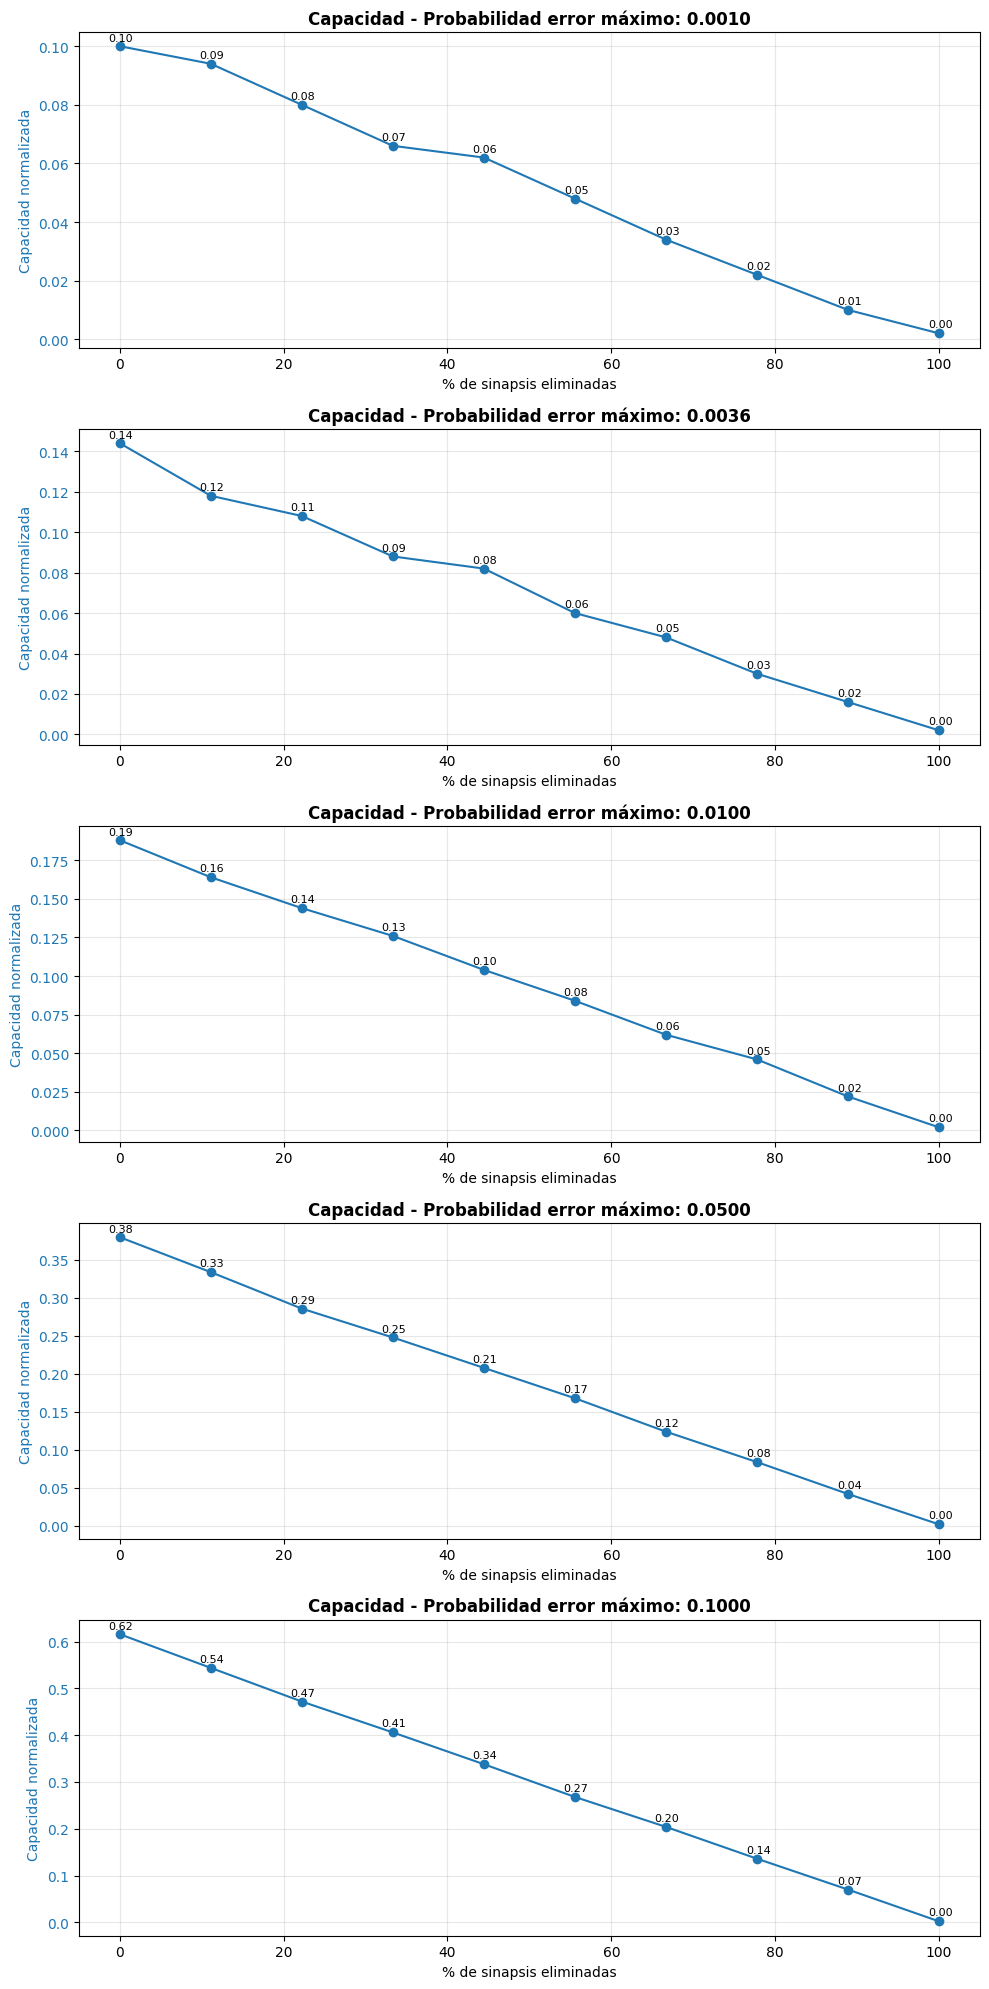

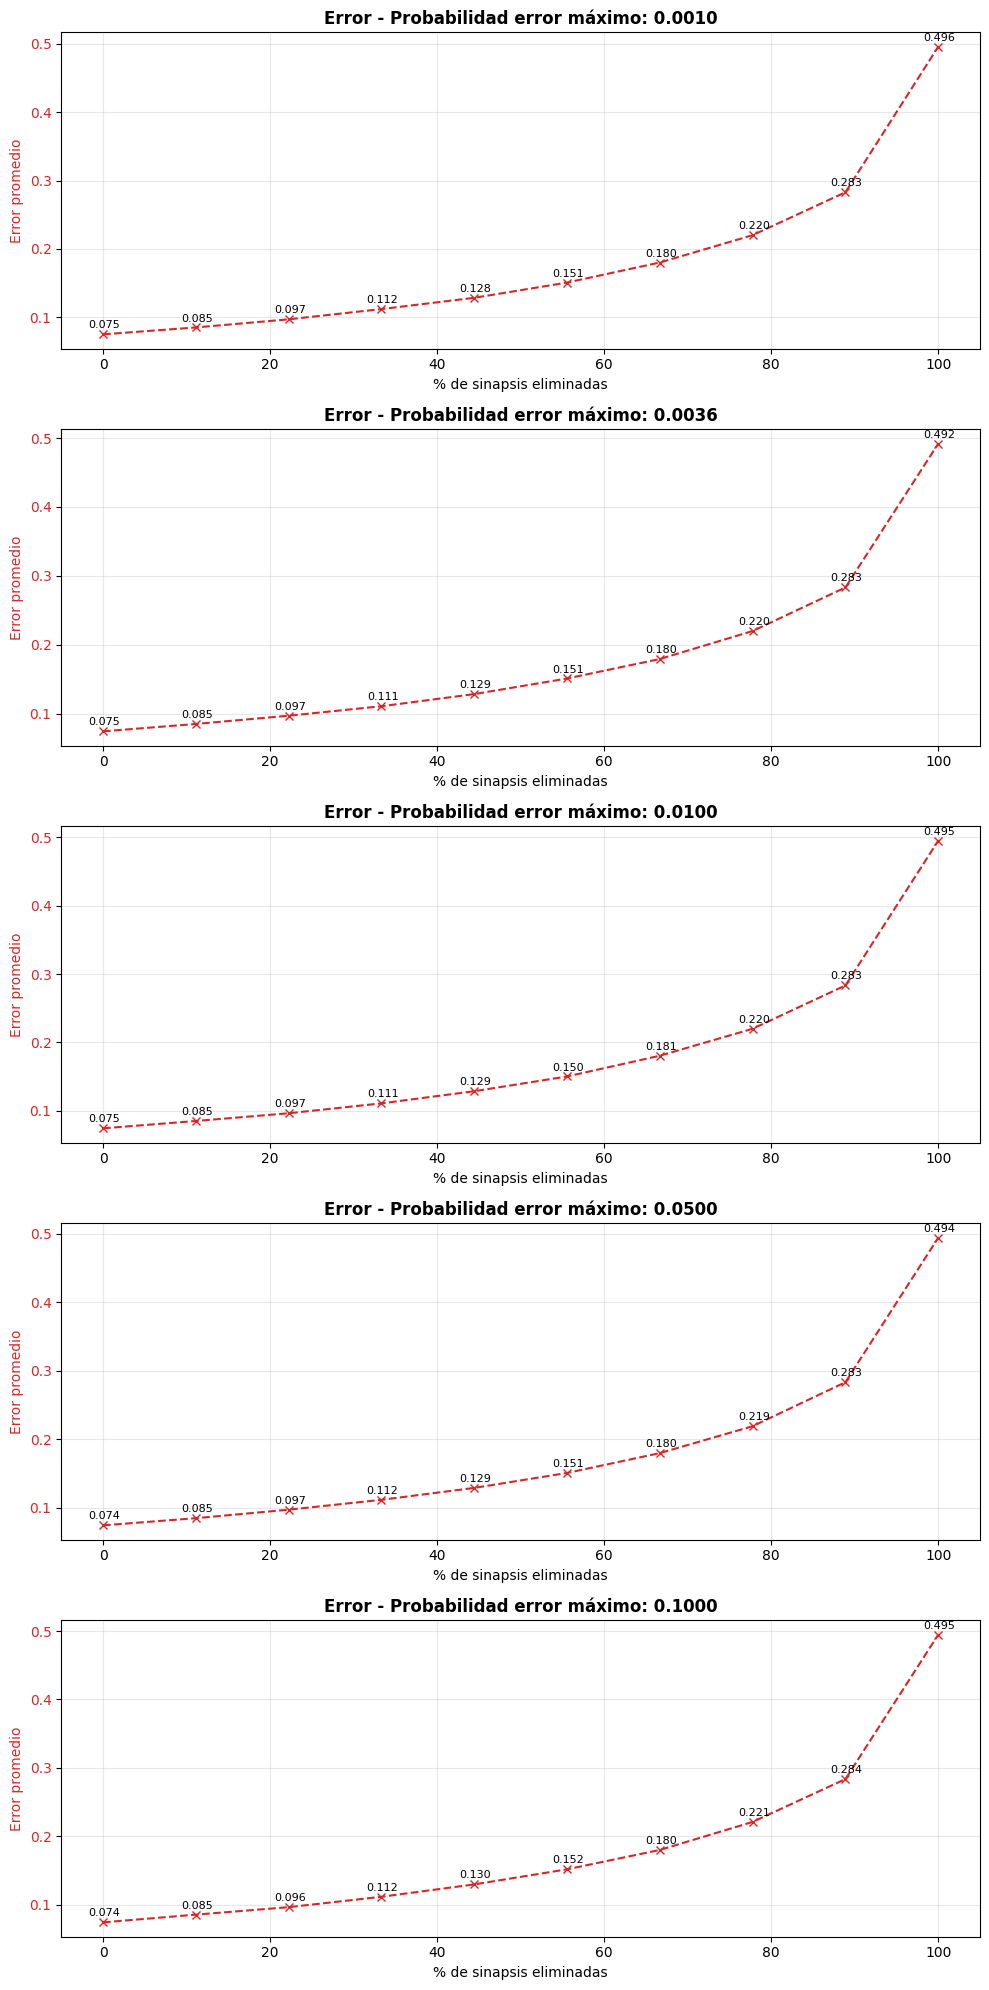

In [33]:
def analizar_capacidad_vs_sinapsis_separado(n_neuronas=10, prob_error_max_list=[0.001, 0.0036, 0.01, 0.05, 0.1]):
    """
    Versión con figuras separadas para capacidad y error
    """
    porcentajes = np.linspace(0, 1, 10)
    
    n_plots = len(prob_error_max_list)
    
    # Crear dos figuras: una para capacidad, otra para error
    fig_cap, axes_cap = plt.subplots(n_plots, 1, figsize=(10, 4*n_plots))
    fig_err, axes_err = plt.subplots(n_plots, 1, figsize=(10, 4*n_plots))
    
    if n_plots == 1:
        axes_cap = [axes_cap]
        axes_err = [axes_err]
    
    for i, prob_error_max in enumerate(prob_error_max_list):
        capacidades = []
        errores_promedios = []
        
        for p in porcentajes:
            ERN = evaluacion_capacidad_red_neuronal(n_neuronas)
            ERN.eliminar_sinapsis(p)
            errores, n_patrones = ERN.estimar_errores_vs_patrones()
            capacidad = ERN.capacidad_dada_proba(errores, n_patrones, prob_error_max=prob_error_max)
            
            capacidades.append(capacidad / n_neuronas)
            errores_promedios.append(np.mean(errores))
        
        # FIGURA DE CAPACIDAD
        ax_cap = axes_cap[i]
        color_cap = 'tab:blue'
        ax_cap.set_xlabel('% de sinapsis eliminadas')
        ax_cap.set_ylabel('Capacidad normalizada', color=color_cap)
        line_cap = ax_cap.plot(porcentajes*100, capacidades, marker='o', 
                              color=color_cap, label='Capacidad')
        ax_cap.tick_params(axis='y', labelcolor=color_cap)
        ax_cap.set_title(f'Capacidad - Probabilidad error máximo: {prob_error_max:.4f}', 
                        fontsize=12, fontweight='bold')
        ax_cap.grid(True, alpha=0.3)
        
        # Etiquetas para capacidad
        texts_cap = []
        for x, y in zip(porcentajes*100, capacidades):
            texts_cap.append(ax_cap.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=8))
        adjust_text(texts_cap, ax=ax_cap)
        
        # FIGURA DE ERROR
        ax_err = axes_err[i]
        color_err = 'tab:red'
        ax_err.set_xlabel('% de sinapsis eliminadas')
        ax_err.set_ylabel('Error promedio', color=color_err)
        line_err = ax_err.plot(porcentajes*100, errores_promedios, marker='x', linestyle='--',
                              color=color_err, label='Error')
        ax_err.tick_params(axis='y', labelcolor=color_err)
        ax_err.set_title(f'Error - Probabilidad error máximo: {prob_error_max:.4f}', 
                        fontsize=12, fontweight='bold')
        ax_err.grid(True, alpha=0.3)
        
        # Etiquetas para error
        texts_err = []
        for x, y in zip(porcentajes*100, errores_promedios):
            texts_err.append(ax_err.text(x, y, f'{y:.3f}', ha='center', va='bottom', fontsize=8))
        adjust_text(texts_err, ax=ax_err)
    
    # Ajustar layout
    fig_cap.tight_layout()
    fig_err.tight_layout()
    
    # Mostrar figuras
    plt.show()
    
    return fig_cap, fig_err

# Uso de la función
fig_cap, fig_err = analizar_capacidad_vs_sinapsis_separado(n_neuronas=500)

El análisis de este inciso se hizo directamente en el informe. 